# 2. Load and explore audio datasets

We can load an explore audio datasets using the huggingface library 🤗*Datasets*. Whether you want to use a local dataset or one of the available at huggingface hub, you can take advantage of the library to preprocess your dataset using speed up techniques like batch processing, multiprocessing and caching.

In this notebook we would learn to:

* Load a local audio dataset.
* Load an audio dataset on the huggingface hub.
* Preprocess audio datasets.
* Load an audio dataset using streaming mode.

In [3]:
!pip install datasets -q
!pip install transformers -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.6/519.6 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 12.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 23.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 58.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 55.8 MB/s eta 0:00:00


## Loading local datasets

Let's start by loading a local dataset, we are going to create a toy dataset of 2000 sinusoids.

In [4]:
import numpy as np
import os
import soundfile as sf

fs = 16_000
t = np.linspace(0,1,fs)

# create data path
if not os.path.exists("/content/sinusoids"):
  os.mkdir("/content/sinusoids")

# create 2000 random sinusoids and store
for _ in range(2000):
  f = np.random.randint(low=100,high=5000)
  a = np.random.random()
  x = a*np.cos(2*np.pi*f*t)
  sf.write(file=os.path.join( "/content/sinusoids" ,f"sinusoid_{f}hz_{a}.wav"),
           data=x,
           samplerate=fs)


Now that we have some audio files in our system we can load it using the `from_dict` method, passing a dictionary with the paths of the audio files.

`{"audio":["/path/to/audio_1.wav", "/path/to/audio_2.wav", ..., "/path/to/audio_n.wav"]`


In [5]:
from datasets import Dataset, Audio
import glob
import numpy as np

audio_paths = glob.glob("/content/sinusoids/*.wav")
local_ds = Dataset.from_dict({"audio":audio_paths})
print(local_ds)
print("Dataset sample" ,local_ds[0])

Dataset({
    features: ['audio'],
    num_rows: 2000
})
Dataset sample {'audio': '/content/sinusoids/sinusoid_649hz_0.18551006437053097.wav'}


Now we can cast this column to be of `Audio` type to have a ready to use audio dataset. At this point you can just do `local_ds.push_to_hub()`to share your dataset with the 🌎 world.

In [6]:
local_ds = local_ds.cast_column("audio",Audio())
local_ds[0]

{'audio': {'path': '/content/sinusoids/sinusoid_649hz_0.18551006437053097.wav',
  'array': array([0.18548584, 0.17950439, 0.16189575, ..., 0.16189575, 0.17950439,
         0.18548584]),
  'sampling_rate': 16000}}

## Loading huggingface hub datasets

If our dataset lives in the hub, we use the method `load_dataset` with the dataset handler. Depending on the dataset you can load all the data, single splits and even custom splits



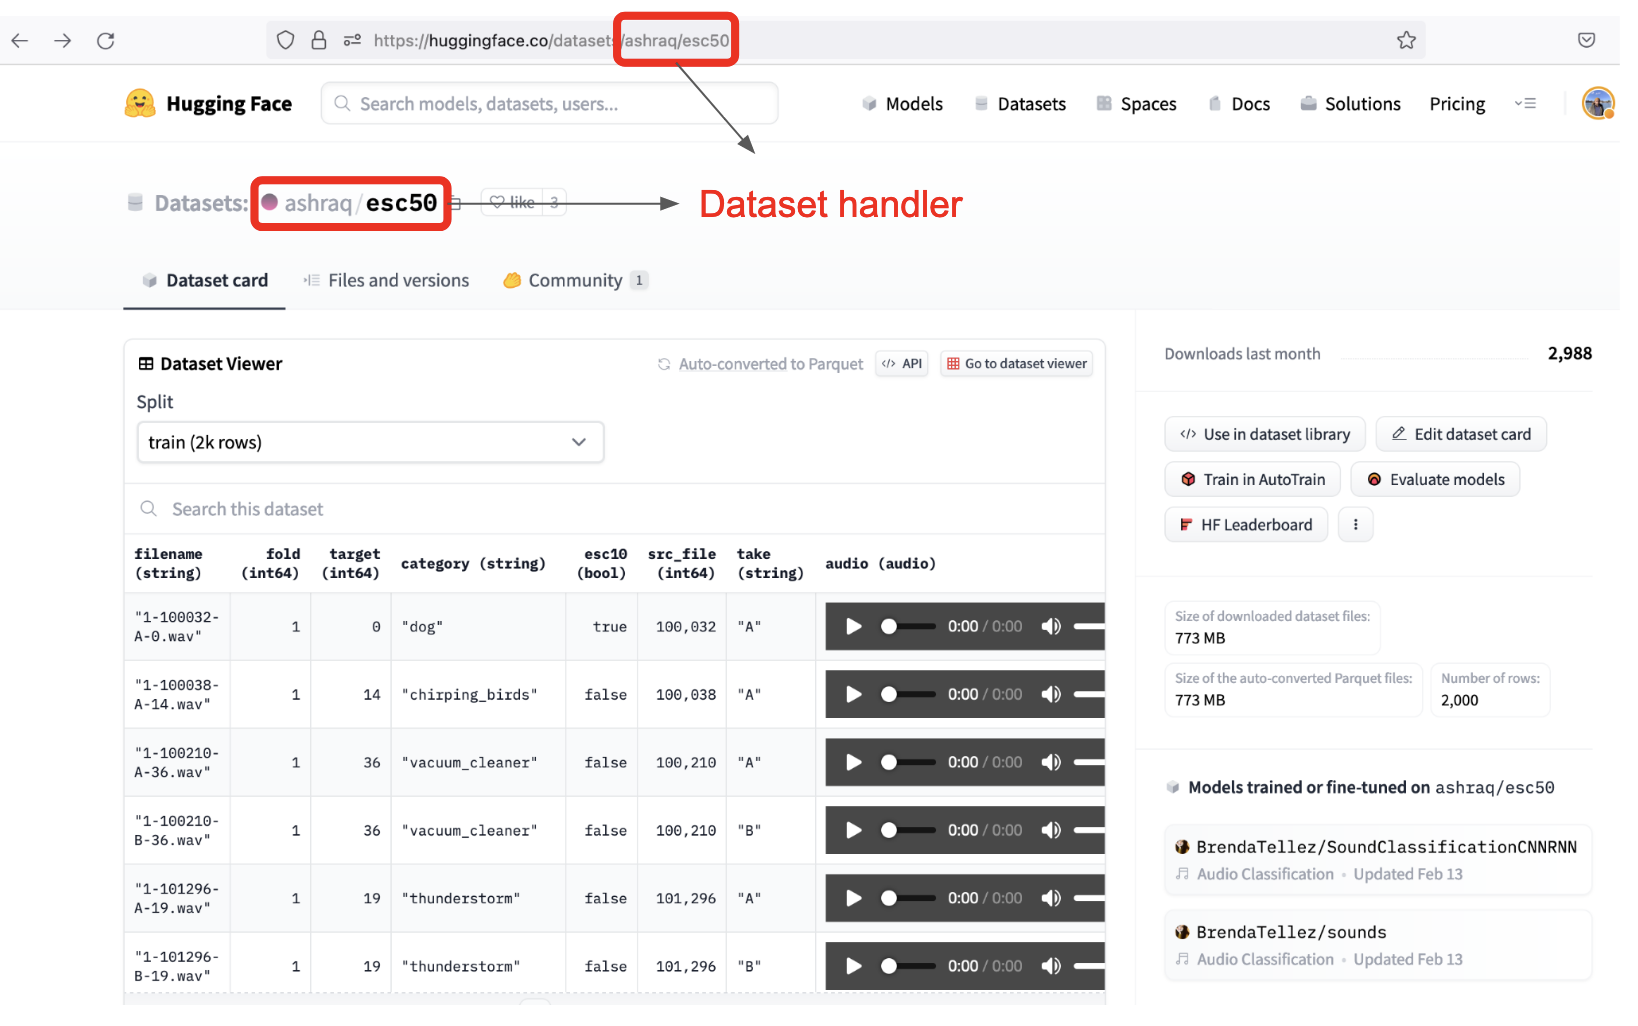

In [7]:
from datasets import load_dataset

esc_ds = load_dataset("ashraq/esc50")

Repo card metadata block was not found. Setting CardData to empty.


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/2000 [00:00<?, ? examples/s]

There are some important details that we have to be aware when using datasets:

* When you load a dataset the processing scripts and data are stored locally by default on the directory ~/.cache/huggingface/datasets.

* The cache allows 🤗 Datasets to avoid re-downloading or processing the entire dataset every time you use it.

* You can change the cache location by:
  - setting the environment variable `HF_DATASETS_CACHE` to another directory.
  - Passing the argument cache_dir with the new directory.

In [8]:
esc_ds["train"][0]

{'filename': '1-100032-A-0.wav',
 'fold': 1,
 'target': 0,
 'category': 'dog',
 'esc10': True,
 'src_file': 100032,
 'take': 'A',
 'audio': {'path': None,
  'array': array([0., 0., 0., ..., 0., 0., 0.]),
  'sampling_rate': 44100}}

**Datasets** uses Arrow for its local caching system. This provides an efficient interface to perform quering, processing and conversions of large data. You can retrieve the cache files of your dataset with `cache_files` property.

In [9]:
esc_ds.cache_files

{'train': [{'filename': '/root/.cache/huggingface/datasets/ashraq___esc50/default-568d830eebf98618/0.0.0/0111277fb19b16f696664cde7f0cb90f833dec72db2cc73cfdf87e697f78fe02/esc50-train.arrow'}]}

## Processing

Processing on the the datasets library is implemented mainly through the **map()** function, however there exists other functions like **cast** and **filter** that are useful in other situations.

The idea is that you write a processing function for a single example of the dataset and the library can do multiprocessing under the hood.

`function(example: dict) -> dict`


Let's try to get the average **zcr** from the audios using `map`


In [10]:
import soundfile as sf
import librosa

def preprocess_function(example):
  zcr = librosa.feature.zero_crossing_rate(example["audio"]["array"],
                                           frame_length=2048,
                                           hop_length=512)

  example["avg_zcr"] = np.mean(zcr)
  return example

In [11]:
local_ds = local_ds.map(preprocess_function)

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

We can do batch processing modifying the preprocessing function as

`function(examples: Dict[List]) -> Dict[List]`

By default map uses a batch size of 1000 examples, depending on your setup you'll have to adjust this number according to your available memory.

Also, make sure that your preprocessing function can handle multi-channel signals. Some libraries like [librosa](https://librosa.org/doc/latest/multichannel.html) support this or you can inherit from `transformers.SequenceFeatureExtractor`


In [12]:
def preprocess_function_batch(batch):

  audio_arrays = np.array([x["array"] for x in batch["audio"]])
  zcrs = librosa.feature.zero_crossing_rate(audio_arrays,
                                           frame_length=2048,
                                           hop_length=512)
  zcrs = zcrs.squeeze(axis=1)

  batch["avg_zcr_2"] = np.mean(zcrs,axis=1)
  return batch

local_ds = local_ds.map(preprocess_function_batch, batched=True, batch_size=32)

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [13]:
local_ds[0]

{'audio': {'path': None,
  'array': array([0.18548584, 0.17950439, 0.16189575, ..., 0.16189575, 0.17950439,
         0.18548584]),
  'sampling_rate': 16000},
 'avg_zcr': 0.077606201171875,
 'avg_zcr_2': 0.077606201171875}

## Streaming mode (Applied problem)

We are going to be using the ***TUT urban acoustic scenes 2018 dataset*** for this tutorial. This dataset has a size of 24Gb, however, we don't have to download it all at once, we can explore it fast with the aid of the streaming mode.

In [14]:
from datasets import load_dataset, Audio

dataset = load_dataset("wetdog/TUT-urban-acoustic-scenes-2018-development-16bit", streaming="True")

Resolving data files:   0%|          | 0/24 [00:00<?, ?it/s]

Every HF Audio dataset has at least a column named "audio" which stores the following features:


        - "path": String with relative path of the audio file to the archive file.
        - "array": Array containing the audio samples
        - "sampling_rate": Integer corresponding to the sampling rate of the audio sample.

We could retrieve the first example of the streaming dataset iterating instead of slicing.

In [15]:
next(iter(dataset["train"]))

{'file_name': 'audio/airport-barcelona-0-0-a.wav',
 'label': 'airport',
 'audio': {'path': 'airport-barcelona-0-0-a.wav',
  'array': array([-2.13623047e-04, -1.37329102e-04, -2.13623047e-04, ...,
          3.05175781e-05, -6.10351562e-05, -6.10351562e-05]),
  'sampling_rate': 48000},
 'city': 'barcelona',
 'location_id': '0'}

Finally, we can plot and hear the sample that we retrieve.

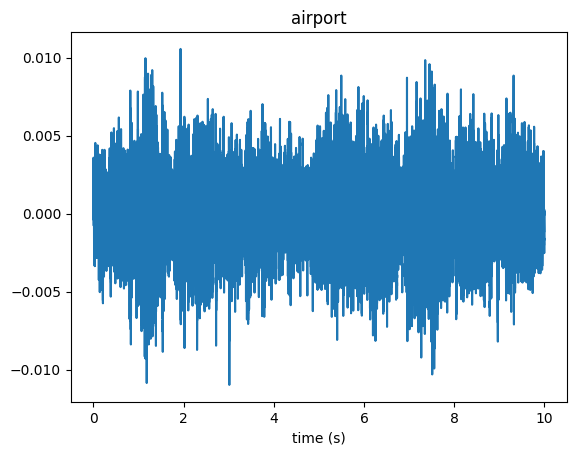

In [16]:
import matplotlib.pyplot as plt
from IPython.display import Audio as Audior
from IPython.display import display


for example in dataset["train"]:

  x = example["audio"]["array"]
  fs = example["audio"]["sampling_rate"]
  t = np.arange(len(x))/fs

  plt.plot(t, x)
  plt.title(example["label"])
  plt.xlabel("time (s)")
  display(Audior(data=x, rate=fs))
  break